In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import ee
import datetime

ee.Authenticate()
ee.Initialize(project='your_project_id')

geometry = ee.Geometry.Polygon([
    [[-92.7583, 29.6320], [-92.7292, 29.6320],
     [-92.7292, 29.6200], [-92.7583, 29.6200]]
])

dataset = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(geometry) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

def create_rgb(image):
    return image.visualize(
        bands=['B4', 'B3', 'B2'],
        min=0,
        max=3000
    )

def export_image(image, year, index):
    task = ee.batch.Export.image.toDrive(
        image=image.clip(geometry),
        description=f'natural_color_image_{year}_{index}',
        folder='EarthEngineExports',
        fileNamePrefix=f'natural_image_{year}_{index}',
        region=geometry.toGeoJSON()['coordinates'],
        scale=10,
        crs='EPSG:4326',
        maxPixels=1e13
    )
    task.start()
    print(f"Export task started for year {year}, image {index}")

start_year = 2015
end_year = 2023

for year in range(start_year, end_year + 1):
    start_date = datetime.date(year, 1, 1).strftime('%Y-%m-%d')
    end_date = datetime.date(year, 12, 31).strftime('%Y-%m-%d')
    yearly_images = dataset.filterDate(start_date, end_date).map(create_rgb)

    images_to_export = yearly_images.toList(5)
    for i in range(5):
        export_image(ee.Image(images_to_export.get(i)), year, i)

print("All export tasks started. Check your Google Drive under 'EarthEngineExports'.")


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


Export task started for year 2015, image 0
Export task started for year 2015, image 1
Export task started for year 2015, image 2
Export task started for year 2015, image 3
Export task started for year 2015, image 4
Export task started for year 2016, image 0
Export task started for year 2016, image 1
Export task started for year 2016, image 2
Export task started for year 2016, image 3
Export task started for year 2016, image 4
Export task started for year 2017, image 0
Export task started for year 2017, image 1
Export task started for year 2017, image 2
Export task started for year 2017, image 3
Export task started for year 2017, image 4
Export task started for year 2018, image 0
Export task started for year 2018, image 1
Export task started for year 2018, image 2
Export task started for year 2018, image 3
Export task started for year 2018, image 4
Export task started for year 2019, image 0
Export task started for year 2019, image 1
Export task started for year 2019, image 2
Export task

In [7]:
!pip install rasterio

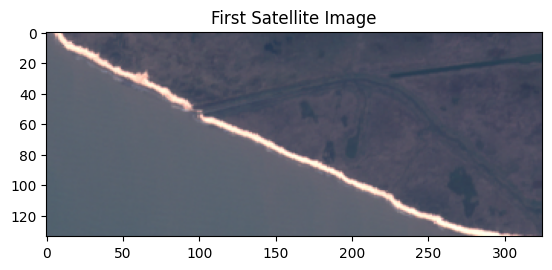

In [18]:
import rasterio
import glob
import numpy as np
import matplotlib.pyplot as plt

image_folder = "/content/drive/MyDrive/EarthEngineExports"

image_files = glob.glob(image_folder + "/*.tif")
images = []

for file in image_files:
    with rasterio.open(file) as src:
        image = src.read()
        images.append(image)

images = np.array(images)

plt.imshow(np.transpose(images[0][:3], (1, 2, 0)))
plt.title("First Satellite Image")
plt.show()


In [34]:

# Comparison Visualization
image_index1 = widgets.IntSlider(min=0, max=len(images) - 1, step=1, value=0, description='Image 1 Index:')
image_index2 = widgets.IntSlider(min=0, max=len(images) - 1, step=1, value=1, description='Image 2 Index:')
comparison_output = widgets.Output()

def on_comparison_change(change):
    with comparison_output:
        clear_output(wait=True)
        index1 = image_index1.value
        index2 = image_index2.value

        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        axes[0].imshow(np.transpose(images[index1][:3], (1, 2, 0)))
        axes[0].set_title(f"Satellite Image {index1}")

        axes[1].imshow(np.transpose(images[index2][:3], (1, 2, 0)))
        axes[1].set_title(f"Satellite Image {index2}")

        diff = np.abs(np.transpose(images[index1][:3], (1, 2, 0)) - np.transpose(images[index2][:3], (1, 2, 0)))
        fig, ax = plt.subplots(figsize=(8,6))
        ax.imshow(diff)
        ax.set_title("Absolute Difference")

        plt.show()

image_index1.observe(on_comparison_change, names='value')
image_index2.observe(on_comparison_change, names='value')

display(image_index1, image_index2, comparison_output)

IntSlider(value=0, description='Image 1 Index:', max=43)

IntSlider(value=1, description='Image 2 Index:', max=43)

Output()

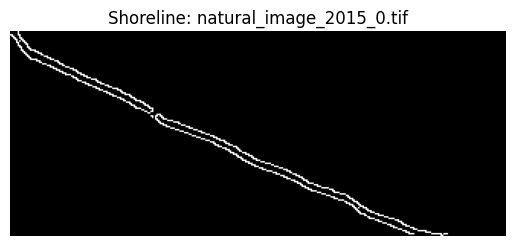

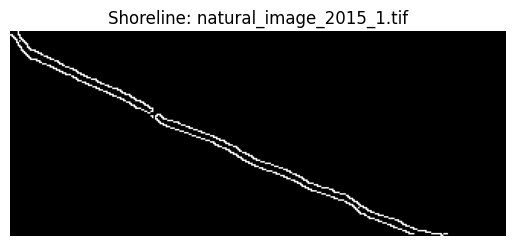

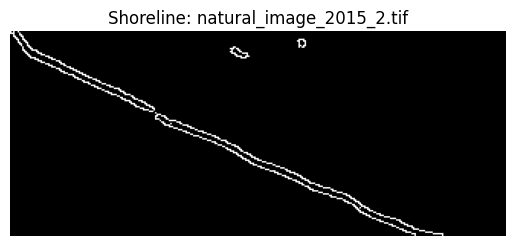

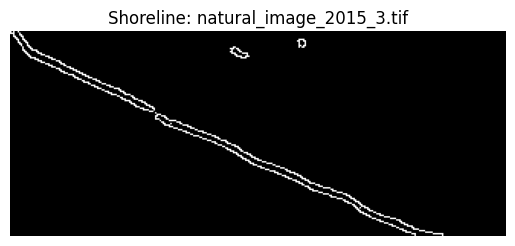

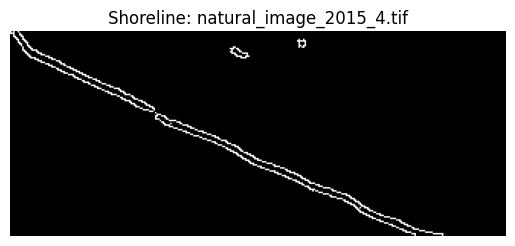

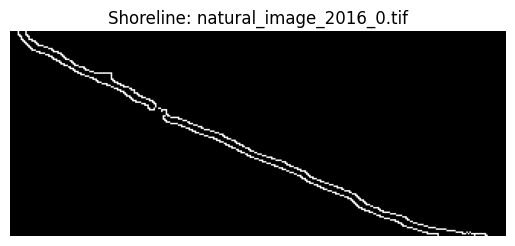

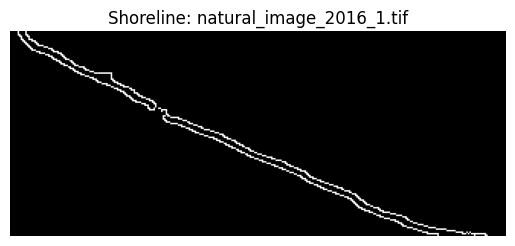

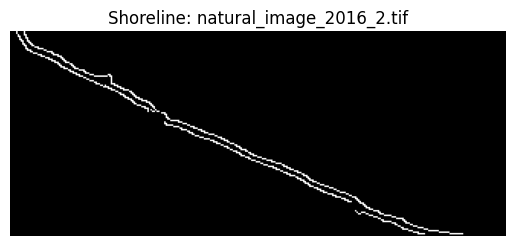

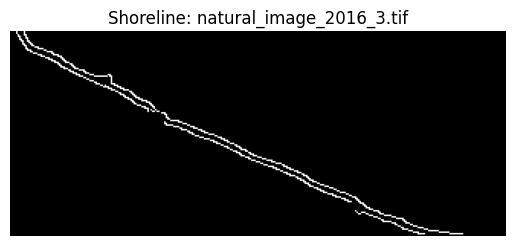

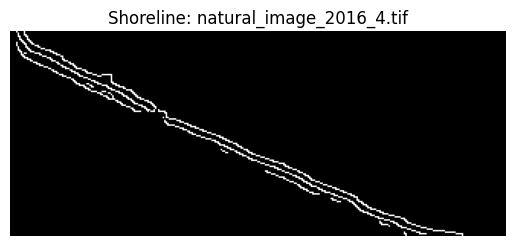

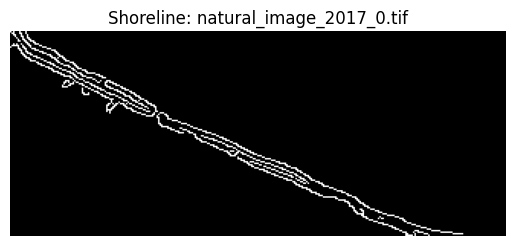

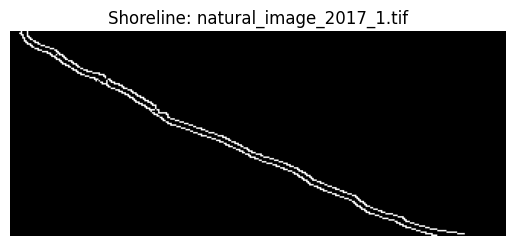

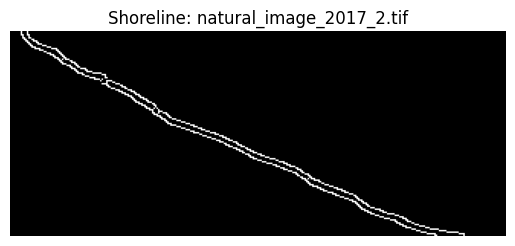

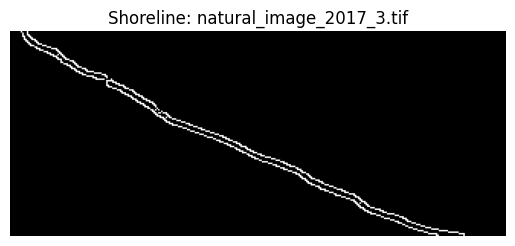

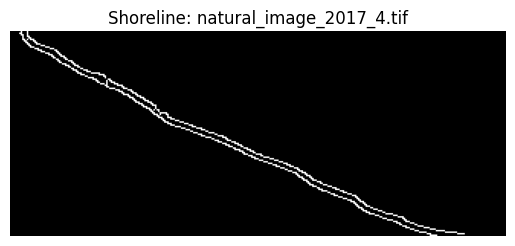

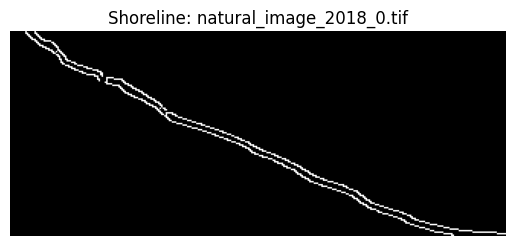

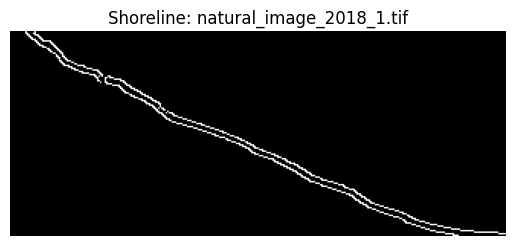

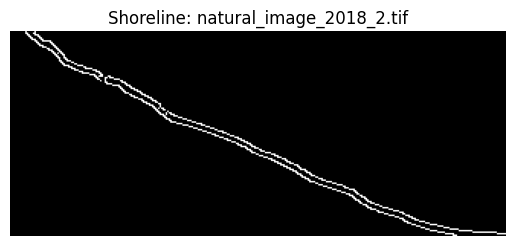

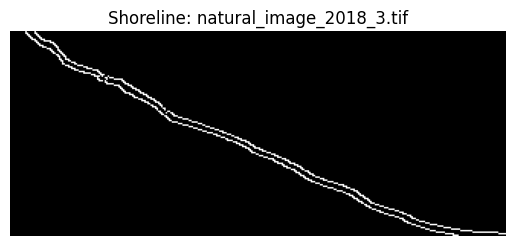

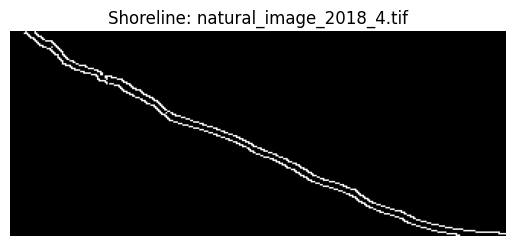

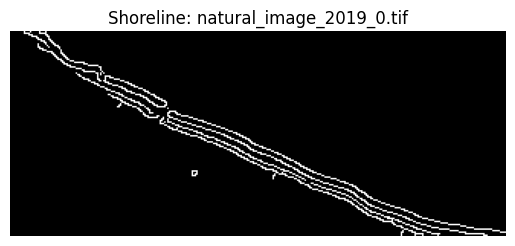

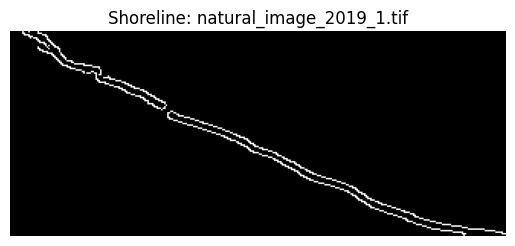

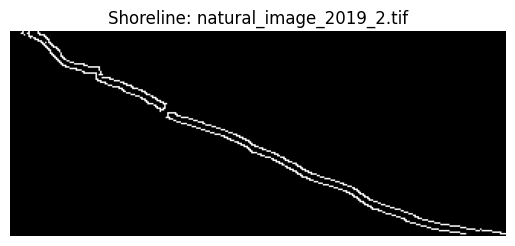

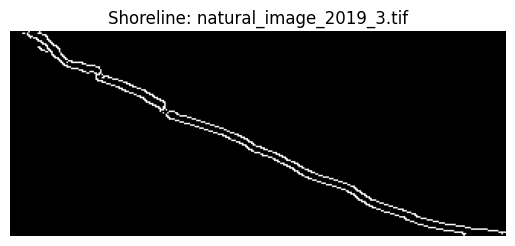

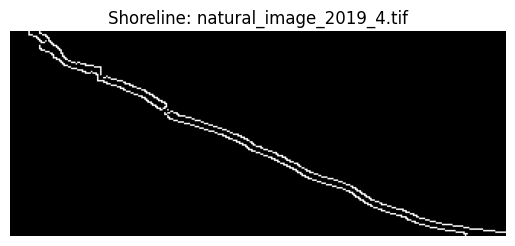

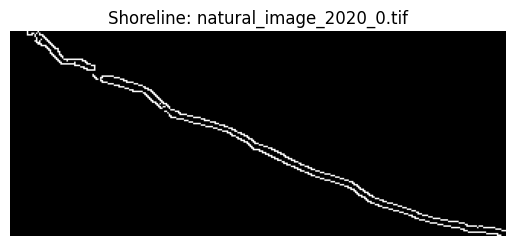

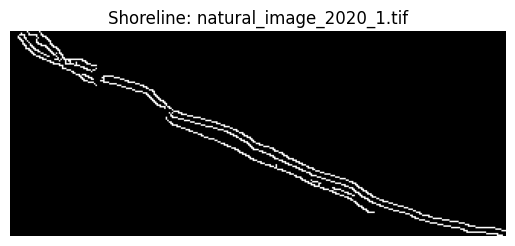

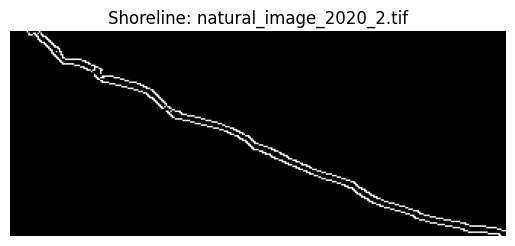

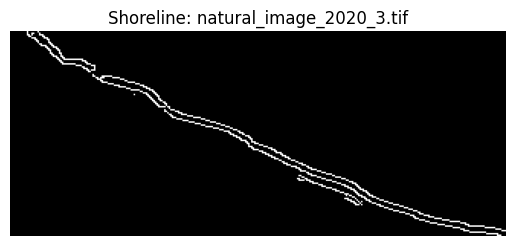

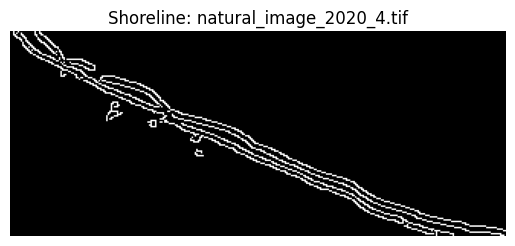

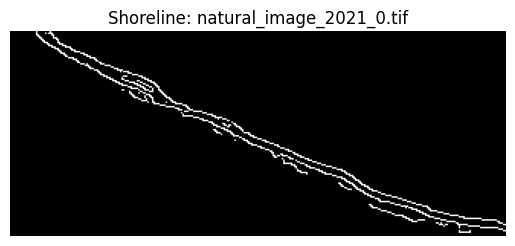

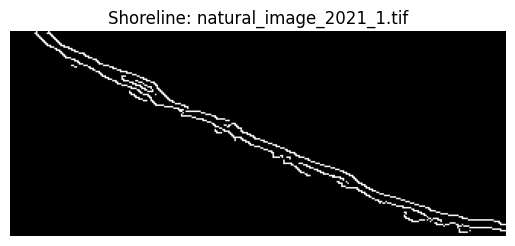

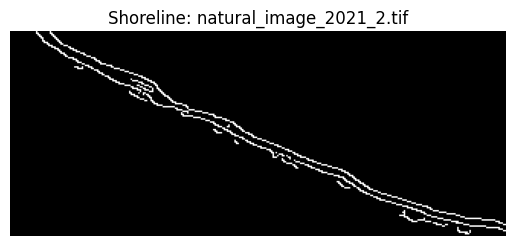

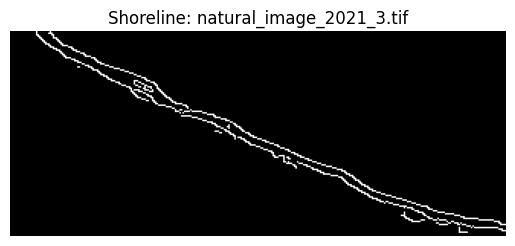

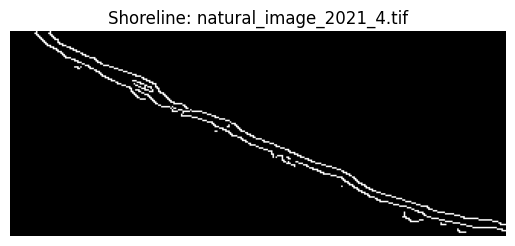

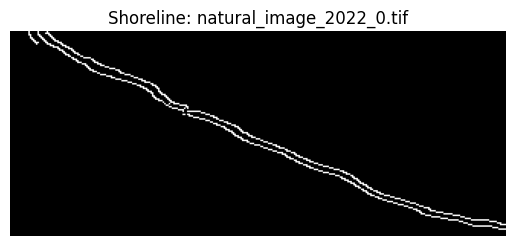

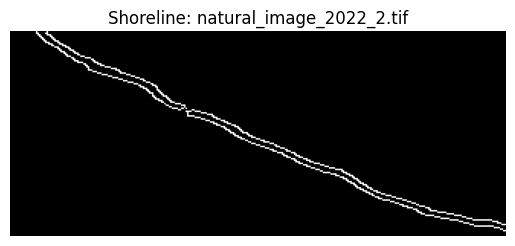

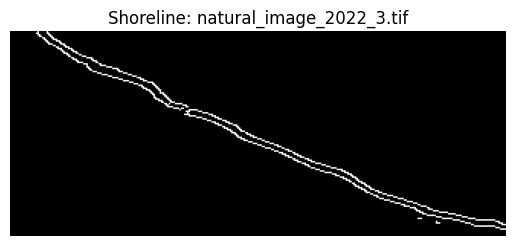

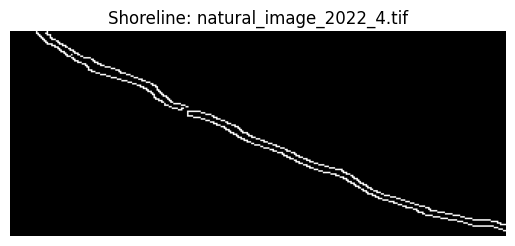

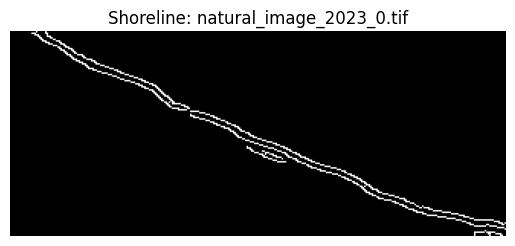

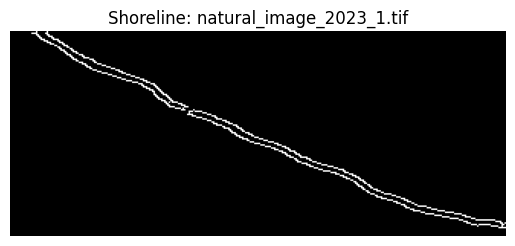

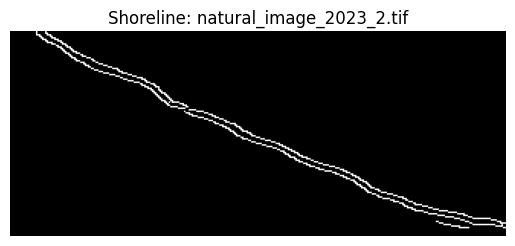

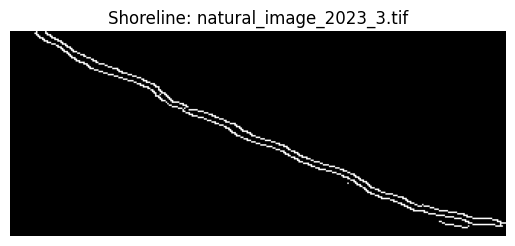

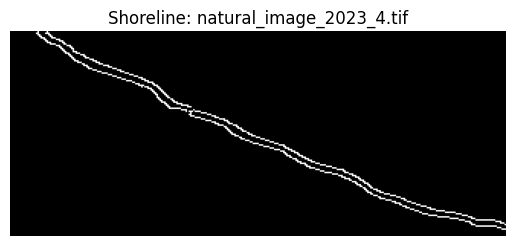

In [39]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

data_dir = '/content/drive/My Drive/EarthEngineExports'

def detect_shoreline(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not load {image_path}")
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, threshold1=50, threshold2=150)
    return edges

image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.tif')])
shorelines = []

for img_file in image_files:
    file_path = os.path.join(data_dir, img_file)
    edges = detect_shoreline(file_path)
    if edges is not None:
        shorelines.append((img_file, edges))
        plt.figure()
        plt.title(f"Shoreline: {img_file}")
        plt.imshow(edges, cmap='gray')
        plt.axis('off')
        plt.show()


In [45]:
shoreline_areas = []
for img_file, edges in shorelines:
    # Calculate the area of the shoreline
    area = np.sum(edges > 0)
    shoreline_areas.append((img_file, area))

# Print the shoreline areas
for img_file, area in shoreline_areas:
    print(f"Shoreline area for {img_file}: {area} pixels")

Shoreline area for natural_image_2015_0.tif: 733 pixels
Shoreline area for natural_image_2015_1.tif: 733 pixels
Shoreline area for natural_image_2015_2.tif: 777 pixels
Shoreline area for natural_image_2015_3.tif: 777 pixels
Shoreline area for natural_image_2015_4.tif: 778 pixels
Shoreline area for natural_image_2016_0.tif: 752 pixels
Shoreline area for natural_image_2016_1.tif: 752 pixels
Shoreline area for natural_image_2016_2.tif: 700 pixels
Shoreline area for natural_image_2016_3.tif: 700 pixels
Shoreline area for natural_image_2016_4.tif: 923 pixels
Shoreline area for natural_image_2017_0.tif: 1150 pixels
Shoreline area for natural_image_2017_1.tif: 731 pixels
Shoreline area for natural_image_2017_2.tif: 736 pixels
Shoreline area for natural_image_2017_3.tif: 734 pixels
Shoreline area for natural_image_2017_4.tif: 732 pixels
Shoreline area for natural_image_2018_0.tif: 763 pixels
Shoreline area for natural_image_2018_1.tif: 765 pixels
Shoreline area for natural_image_2018_2.tif: 76

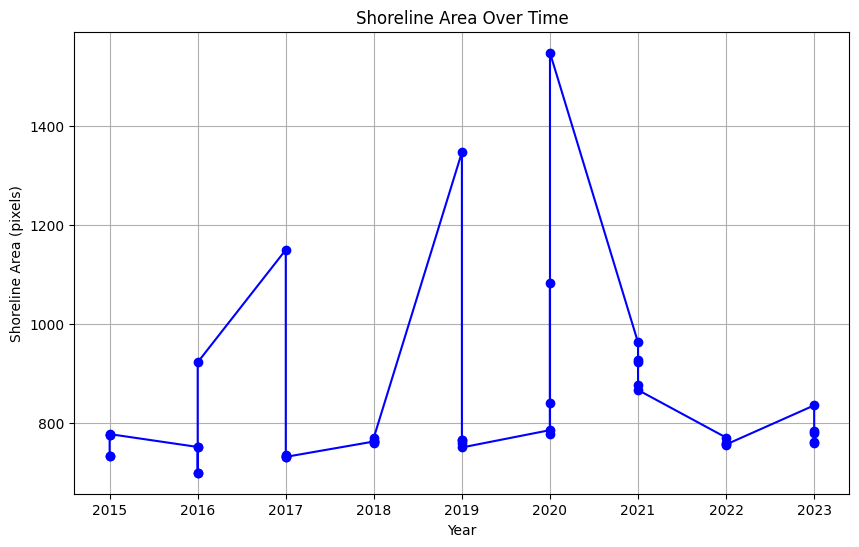

In [46]:
# Extract years from filenames
years = [int(img.split('_')[2]) for img, _ in shoreline_areas]
areas = [area for _, area in shoreline_areas]

# Plot shoreline area over time
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(years, areas, marker='o', linestyle='-', color='blue')
plt.title('Shoreline Area Over Time')
plt.xlabel('Year')
plt.ylabel('Shoreline Area (pixels)')
plt.grid()
plt.show()


Average X-position for natural_image_2015_0.tif: 133.3369713506139
Average X-position for natural_image_2015_1.tif: 133.3369713506139
Average X-position for natural_image_2015_2.tif: 135.47104247104247
Average X-position for natural_image_2015_3.tif: 135.47104247104247
Average X-position for natural_image_2015_4.tif: 135.66066838046274
Average X-position for natural_image_2016_0.tif: 145.3125
Average X-position for natural_image_2016_1.tif: 145.3125
Average X-position for natural_image_2016_2.tif: 137.73714285714286
Average X-position for natural_image_2016_3.tif: 137.73714285714286
Average X-position for natural_image_2016_4.tif: 130.74431202600218
Average X-position for natural_image_2017_0.tif: 120.20695652173913
Average X-position for natural_image_2017_1.tif: 140.97127222982215
Average X-position for natural_image_2017_2.tif: 142.14809782608697
Average X-position for natural_image_2017_3.tif: 141.52316076294278
Average X-position for natural_image_2017_4.tif: 140.4262295081967
Ave

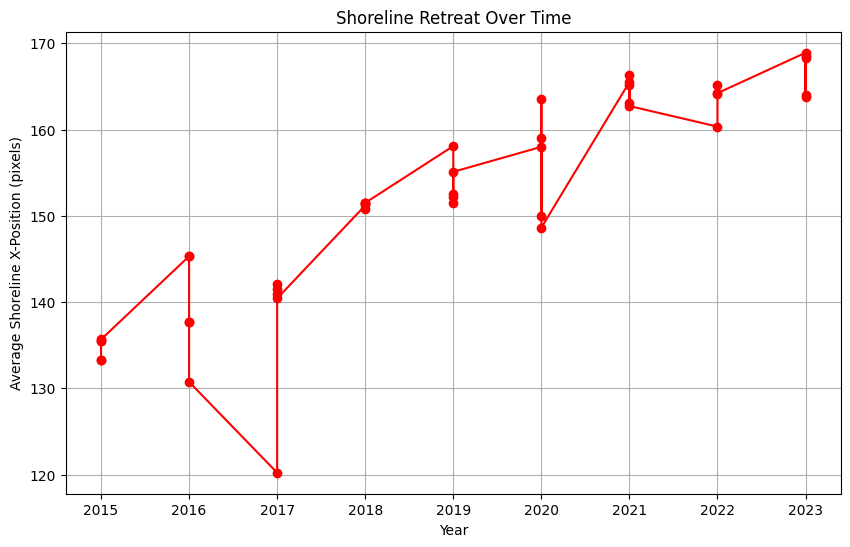

In [53]:
# Function to calculate the average X-position of the shoreline
def calculate_shoreline_position(edges):
    y_indices, x_indices = np.where(edges > 0)
    return np.mean(x_indices) if len(x_indices) > 0 else None

shoreline_positions = []

for img_file, edges in shorelines:
    avg_position = calculate_shoreline_position(edges)
    shoreline_positions.append((img_file, avg_position))
    print(f"Average X-position for {img_file}: {avg_position}")

years = [int(img.split('_')[2]) for img, _ in shoreline_positions]
# Extract positions from shoreline_positions
positions = [pos for _, pos in shoreline_positions] # This line is added to extract the positions

plt.figure(figsize=(10, 6))
plt.plot(years, positions, marker='o', linestyle='-', color='red') # Now using the extracted positions
plt.title('Shoreline Retreat Over Time')
plt.xlabel('Year')
plt.ylabel('Average Shoreline X-Position (pixels)')
plt.grid()
plt.show()

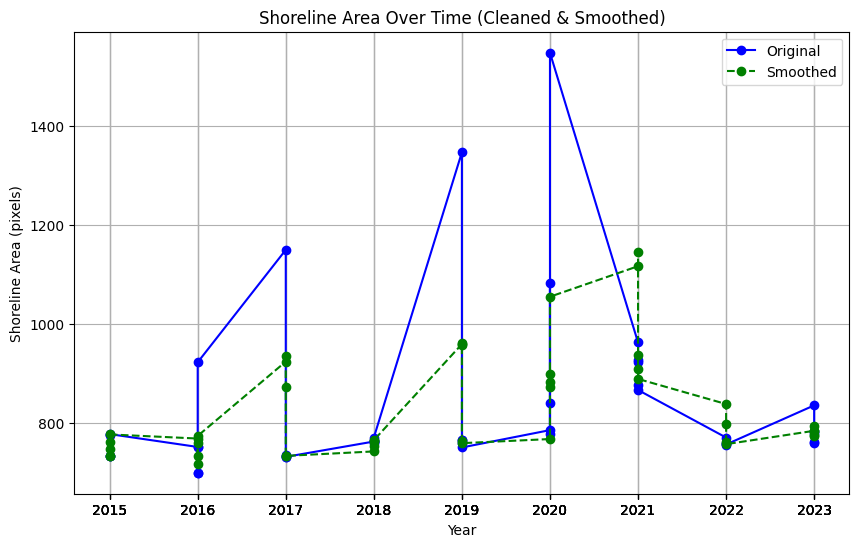

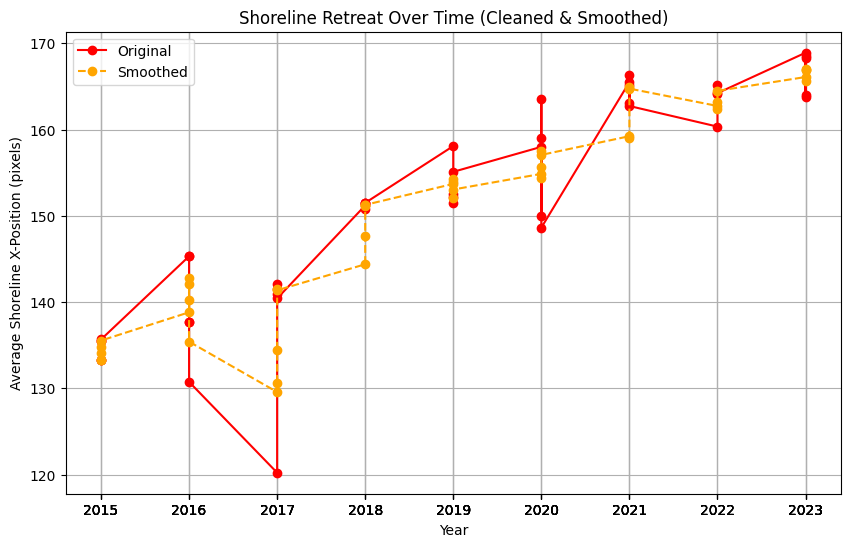

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

min_len = min(len(years), len(areas), len(positions))

years = years[:min_len]
areas = areas[:min_len]
positions = positions[:min_len]

data = pd.DataFrame({'Year': years, 'Area': areas, 'Position': positions})

data_cleaned = data[data['Area'] < 2000].reset_index(drop=True)

data_cleaned['Smoothed_Area'] = data_cleaned['Area'].rolling(window=3, min_periods=1).mean()
data_cleaned['Smoothed_Position'] = data_cleaned['Position'].rolling(window=3, min_periods=1).mean()

plt.figure(figsize=(10, 6))
plt.plot(data_cleaned['Year'], data_cleaned['Area'], marker='o', linestyle='-', color='blue', label='Original')
plt.plot(data_cleaned['Year'], data_cleaned['Smoothed_Area'], marker='o', linestyle='--', color='green', label='Smoothed')
plt.title('Shoreline Area Over Time (Cleaned & Smoothed)')
plt.xlabel('Year')
plt.ylabel('Shoreline Area (pixels)')
plt.xticks(data_cleaned['Year'])
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(data_cleaned['Year'], data_cleaned['Position'], marker='o', linestyle='-', color='red', label='Original')
plt.plot(data_cleaned['Year'], data_cleaned['Smoothed_Position'], marker='o', linestyle='--', color='orange', label='Smoothed')
plt.title('Shoreline Retreat Over Time (Cleaned & Smoothed)')
plt.xlabel('Year')
plt.ylabel('Average Shoreline X-Position (pixels)')
plt.xticks(data_cleaned['Year'])
plt.legend()
plt.grid()
plt.show()


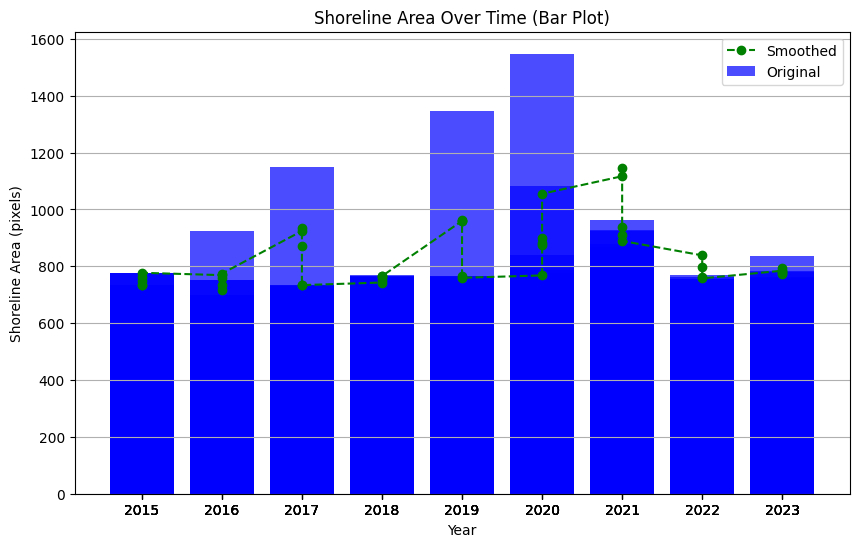

In [55]:
# Bar plot for Shoreline Area
plt.figure(figsize=(10, 6))
plt.bar(data_cleaned['Year'], data_cleaned['Area'], color='blue', alpha=0.7, label='Original')
plt.plot(data_cleaned['Year'], data_cleaned['Smoothed_Area'], marker='o', linestyle='--', color='green', label='Smoothed')
plt.title('Shoreline Area Over Time (Bar Plot)')
plt.xlabel('Year')
plt.ylabel('Shoreline Area (pixels)')
plt.xticks(data_cleaned['Year'])
plt.legend()
plt.grid(axis='y')
plt.show()


In [56]:
# Calculate total shoreline retreat
total_retreat = data_cleaned['Position'].iloc[-1] - data_cleaned['Position'].iloc[0]
print(f"Total Shoreline Retreat (pixels): {total_retreat}")

# Calculate annual retreat rate
years_diff = data_cleaned['Year'].iloc[-1] - data_cleaned['Year'].iloc[0]
annual_retreat_rate = total_retreat / years_diff
print(f"Annual Retreat Rate (pixels per year): {annual_retreat_rate}")


Total Shoreline Retreat (pixels): 30.673527337050132
Annual Retreat Rate (pixels per year): 3.8341909171312665


In [64]:
# Calculate percentage shoreline retreat (assuming a reference point)
initial_position = data_cleaned['Position'].iloc[0]
final_position = data_cleaned['Position'].iloc[-1]
percentage_retreat = ((final_position - initial_position) / final_position) * 100
print(f"Percentage Shoreline Retreat: {percentage_retreat:.2f}%")

average_bus_length_meters = 12.19
annual_retreat_rate_meters = total_retreat / years_diff

annual_retreat_rate_bus_lengths = annual_retreat_rate_meters / average_bus_length_meters
print(f"Annual Retreat Rate is approximately {annual_retreat_rate_bus_lengths:.2f} bus lengths per year")

# Output the total shoreline retreat in meters
print(f"Total Shoreline Retreat: {total_retreat} meters")
print(f"Annual Retreat Rate: {annual_retreat_rate_meters:.2f} meters per year")

Percentage Shoreline Retreat: 18.70%
Annual Retreat Rate is approximately 0.34 bus lengths per year
Total Shoreline Retreat: 33.58487375528628 meters
Annual Retreat Rate: 4.20 meters per year


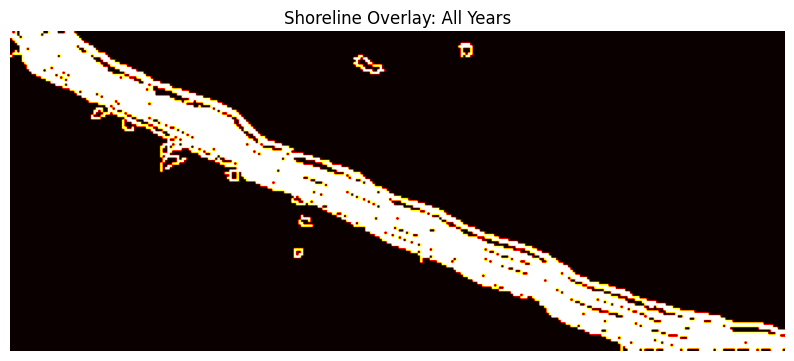

In [99]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

overlay_image = np.zeros_like(shorelines[0][1])

# Add edges from each year to the overlay
for img_file, edges in shorelines:
    overlay_image = cv2.add(overlay_image, edges)

# Plot the overlay
plt.figure(figsize=(10, 6))
plt.title("Shoreline Overlay: All Years")
plt.imshow(overlay_image, cmap='hot')
plt.axis('off')
plt.show()


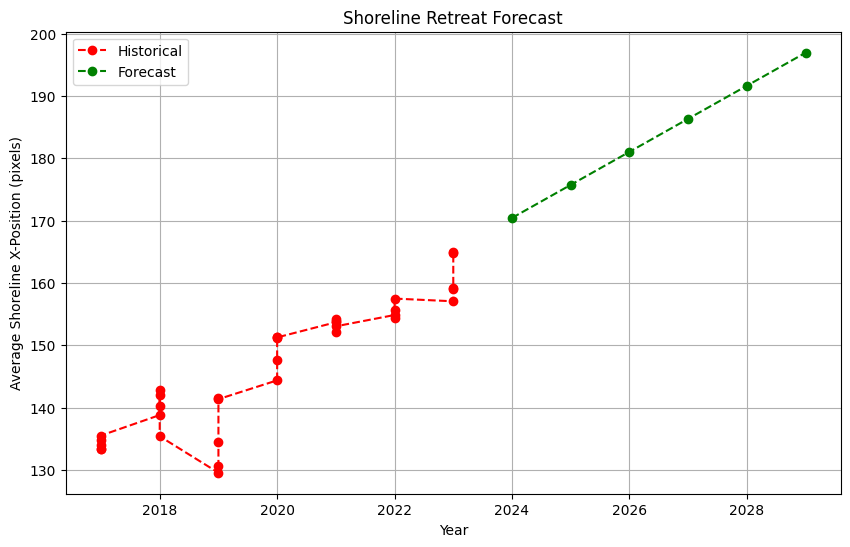

In [97]:
# Forecast future shoreline positions
future_years = np.arange(2024, 2030)
forecast_positions = [data_cleaned['Position'].iloc[-1] + (i - 2023) * annual_retreat_rate for i in future_years]

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(data_cleaned['Year'], data_cleaned['Smoothed_Position'], marker='o', linestyle='--', color='red', label='Historical')
plt.plot(future_years, forecast_positions, marker='o', linestyle='--', color='green', label='Forecast')
plt.title('Shoreline Retreat Forecast')
plt.xlabel('Year')
plt.ylabel('Average Shoreline X-Position (pixels)')
plt.legend()
plt.grid()
plt.show()
